In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/110-1-ntut-dl-app-hw3/IXIC.csv
/kaggle/input/110-1-ntut-dl-app-hw3/nasdaq_predict.csv
/kaggle/input/110-1-ntut-dl-app-hw3/qqq.us.txt


In this project we have to predict the cosing price of NASDAQ index using any AI model

In [2]:
import pandas as pd
df = pd.read_csv("../input/110-1-ntut-dl-app-hw3/IXIC.csv" )
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1971-02-05,100.000000,100.000000,100.000000,100.000000,100.000000,0
1,1971-02-08,100.839996,100.839996,100.839996,100.839996,100.839996,0
2,1971-02-09,100.760002,100.760002,100.760002,100.760002,100.760002,0
3,1971-02-10,100.690002,100.690002,100.690002,100.690002,100.690002,0
4,1971-02-11,101.449997,101.449997,101.449997,101.449997,101.449997,0


To use this data to predict closing price, we must preprocess it thoroughly in order to get most accurate results. We can do that in multiple ways like using scaler, encoding , normalizations etc but we have to carefully decide what to use as the input in this dataset is sensitive.

<function matplotlib.pyplot.show(close=None, block=None)>

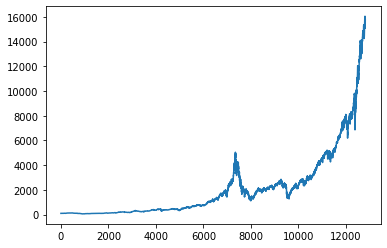

In [3]:
import matplotlib.pyplot as plt
plt.plot(df["Close"])
plt.show

The graph shows an exponential growth in closing price. Also as evident this dataset has continuous values. This is a non linear regression problem and we can solve it by using LSTM(long short term memory), a technique which is widely used in deep learning these days especially for a time series data.

First we will check For missing values.
for that we will use null function

In [4]:
print("Dataframe Shape: ", df. shape)

Dataframe Shape:  (12824, 7)


In [5]:
df.isnull().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

As we can see that any column of df doesnot have any null value, we can continue with out preprocessing.
Volume column seems to have just 0 as their value but we cant remoive it without checking so we will check if there are any other values in Volume.


In [6]:
df['Volume'].unique()

array([         0,   62860000,   58860000, ..., 5095960000, 5091220000,
       4600800000])

We also cant afford to have redundant data and as it seems adj close and close are similar. we will eliminate the column if it is the case.


In [7]:
df['Close'].equals(df['Adj Close'])

True

As the closing price is independent of adj close and date we might as well remove those columns from the dataframe.

In [8]:
data = pd.DataFrame({'Open':df['Open'],'High':df['High'],'Low':df['Low'],'Volume':df['Volume'],'Close':df['Close']})
data.head(10)

,Open,High,Low,Volume,Close
0,100.000000,100.000000,100.000000,0,100.000000
1,100.839996,100.839996,100.839996,0,100.839996
2,100.760002,100.760002,100.760002,0,100.760002
3,100.690002,100.690002,100.690002,0,100.690002
4,101.449997,101.449997,101.449997,0,101.449997
5,102.050003,102.050003,102.050003,0,102.050003
6,102.190002,102.190002,102.190002,0,102.190002
7,101.739998,101.739998,101.739998,0,101.739998
8,101.419998,101.419998,101.419998,0,101.419998
9,100.699997,100.699997,100.699997,0,100.699997


Now in order to use these values we must scale them and since we dont want all the values to be centered around mean we will use min max scaler.

Min Max Scaler is present in sklearn.preprocessing library and we will import it from there.

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
training = scaler.fit_transform(data)

In [10]:
training.shape

(12824, 5)

In [11]:
type(training)

numpy.ndarray

Now to split the data, while incorporating the time steps in between and we will have to use loops since, the "training" data is now in numpy.ndarray form and for it to work on lstm we need x_train and x_test to be in form of 3 dimensional array. I am here incorporating a timestamp of 60.

I did a 9:1 split in training:test

In [12]:
X_train = []
Y_train = []
X_test =[]
Y_test =[]
for i in range(60,10310) :
    
    X_train.append(training[i-60:i,:])
    Y_train.append (training[i, 0])

X_train= np.array(X_train)
Y_train = np.array(Y_train)


for i in range(10310,12824):
    X_test.append(training[i-60:i,:])
    Y_test.append(training[i, 0])
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [13]:
X_train.shape

(10250, 60, 5)

In [14]:
Y_train.shape

(10250,)

In [15]:
X_test.shape

(2514, 60, 5)

In [16]:
Y_test.shape

(2514,)

Now to use LSTM model we need to import the important libraries from keras, for the same. So we imported Sequential, LSTM, Dense.

Sequential is usually used in predicting any thing that has sequence of inputs over a period of time like in stock prediction.





LSTM is a variation in Recurrent Neural Network made just for predictions, classifications and processing, inputs that are time series of data and in this problem we have Stock Market Prediction which is a time series data.

Dense is a layer that is fully connected with neurons of the other layers and it is an integral part of DL.

We can use Dropout in order to relieve some randome neurons while working. It is sort of a regularization technique where a given part of neurons are ignored during training.
But here we only have one layer so it is a shallow neural network, there is no point of introducing dropuout here.

In [17]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

For this model, 32 units of neurons are used, for a train matrix of dimension (m,n,o) we provide input shape with (n,o) since we checked it on previous step i added it here directly.

In this model i used activation function of reLU, as it gives linear output above zero but still is a non-linear function to avoid gradient descent vanishing problem. We set those return_sequences to False which decides whether or not we want to return the last output in the output sequence, or the full sequence.

We set the units of LSTM to be 32 so the dimensionality of the outer space of that layer is 32. We added a Dense Layer with units = 1, so that the outut state of that layer is 1.

Atlast, we compiled the model with adam optimizers, and calculated the loss with 'mean_squared_error' metrics.

In [18]:
lstm_model = Sequential()
lstm_model.add(LSTM(32, input_shape=( 60, 5 ), activation='relu', return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

2022-03-16 09:54:57.985341: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 09:54:58.092657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 09:54:58.093472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 09:54:58.094630: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

We then fit that model onto the training data with 30 epochs and batch size 32.

In [19]:
lstm_model.fit(X_train, Y_train, epochs=30, batch_size=32)

2022-03-16 09:55:00.773745: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
321/321 [==============================] - 32s 95ms/step - loss: 2.0726e-04
Epoch 2/30
321/321 [==============================] - 30s 94ms/step - loss: 7.9257e-06
Epoch 3/30
321/321 [==============================] - 31s 96ms/step - loss: 7.4357e-06
Epoch 4/30
321/321 [==============================] - 32s 99ms/step - loss: 6.7509e-06
Epoch 5/30
321/321 [==============================] - 31s 97ms/step - loss: 5.6225e-06
Epoch 6/30
321/321 [==============================] - 31s 97ms/step - loss: 5.3560e-06
Epoch 7/30
321/321 [==============================] - 31s 98ms/step - loss: 4.9159e-06
Epoch 8/30
321/321 [==============================] - 30s 94ms/step - loss: 4.3208e-06
Epoch 9/30
321/321 [==============================] - 32s 99ms/step - loss: 4.7433e-06
Epoch 10/30
321/321 [==============================] - 31s 98ms/step - loss: 3.9207e-06
Epoch 11/30
321/321 [==============================] - 32s 101ms/step - loss: 3.8468e-06
Epoch 12/30
321/321 [===================

Now predicting the stock price using predict function.

In [20]:
predicted_price = lstm_model.predict(X_test)

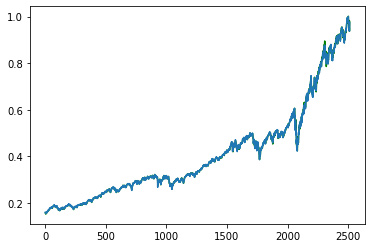

In [21]:
plt.plot(predicted_price,'green', Y_test)
plt.show()

Now that we have predicted output and y_test we can compare them by using r2_score metrics.

In [22]:
from sklearn.metrics import r2_score

r2 = r2_score(Y_test,predicted_price)
r2

0.9995800534679303

In [23]:
print(f'Since the r2_score is {r2},the accuracy is pretty decent and as evident from graph the model is quite efficient!')

Since the r2_score is 0.9995800534679303,the accuracy is pretty decent and as evident from graph the model is quite efficient!
